In [4]:
import sys
print(sys.executable)
!pip install pandas

/home/khulan/anaconda3/bin/python


In [132]:
import pandas as pd
import matplotlib as mpl
from matplotlib import lines
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn import linear_model
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

window = 20
prediction_window = 5
category = pd.read_csv('categorized.csv')
category.index= category.set_index(pd.DatetimeIndex(category.time))
for name, group in category.groupby(category['gateway']):
    group= group.set_index(pd.DatetimeIndex(group.time))
    errors = pd.DataFrame()
    for index, row in group.iterrows():
        if row['category'] == 'Good' and row['count_inconsistent']<row['count_good'] :
            train_window = group[index-pd.Timedelta(minutes=window): index]['latency'].values
            if len(train_window)>window:                
                test_window = group[index+pd.Timedelta(minutes=1): index+pd.Timedelta(minutes=(prediction_window))]['latency'].values
                model = AR(train_window)
                model_fit = model.fit()
                predictions = model_fit.predict(start=(window+1), end=(window+prediction_window), dynamic=False)
                
                if len(test_window) == len(predictions):
                    error = mean_squared_error(test_window, predictions)
                    errors = errors.append({'time':index, 'error':error},ignore_index=True)

    if len(errors) >0:
        errors = errors.set_index(errors['time'])
        errors.to_csv('AR/'+str(prediction_window)+'/prediction_errors/'+name+'.csv')
            
            

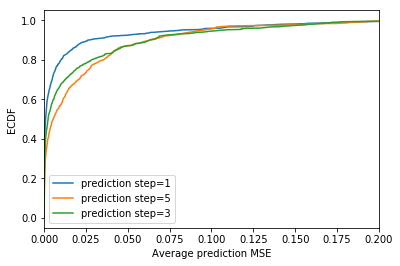

In [133]:
import os
def getECDF(df,column):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df[column].value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()
    return ecdf
legends = []
for dir1 in os.listdir('AR'): 
    legends.append('prediction step='+dir1)
    client_data = pd.DataFrame()
    data = pd.DataFrame()
    INPUT_DIR = os.path.join( os.getcwd(), 'AR/'+dir1+'/prediction_errors')
    data = pd.DataFrame()
    dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR))]    
    for client in dirs:
        client_data = pd.read_csv(os.path.join(INPUT_DIR, client), sep=',')
        client_data.columns= ['time','error','time1']
        client_data = client_data.set_index(pd.DatetimeIndex(client_data['time']))
        client_data = client_data.query('error<2')
        data = pd.concat([data, client_data])

    grouped = data.groupby(data.index).mean()
    getECDF(grouped, 'error').plot()
     
plt.legend(legends)
plt.xlabel('Average prediction MSE')
plt.ylabel('ECDF')
plt.xlim(0,0.2)



plt.show()
#plt.ylim(0,0.001)
